I'm going to follow through the tutorial at http://pymc-devs.github.io/pymc3/notebooks/getting_started.html, which was published as https://peerj.com/articles/cs-55/.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
np.random.seed(123)

# Generate data

In [25]:
# generate data from params that we'll recover
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [26]:
X1[:5], X2[:5]

(array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025]),
 array([ 0.12841094, -0.39557759,  0.14245293,  0.51966079, -0.0049252 ]))

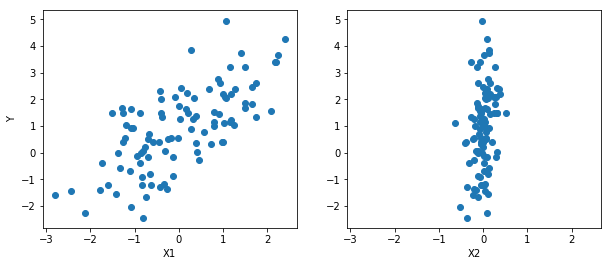

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

# Model specification

In [29]:
from pymc3 import Model, Normal, HalfNormal

In [30]:
basic_model = Model()

with basic_model:
    # priors
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # likelihood of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

# Model fitting

## Maximum a posteriori

MAP gives us the mode of the posterior, using numerical optimization. It does only give us a point value - not a distribution - and we should keep in mind that the mode is not always representative of the distribution. There are more caveats in the tutorial.

In [31]:
from pymc3 import find_MAP

In [32]:
map_estimate = find_MAP(model=basic_model)
map_estimate

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21


{'alpha': array(0.9065985497559482),
 'beta': array([ 0.94848602,  2.60705514]),
 'sigma_log_': array(-0.03278147017403069)}

We can also use different optimization methods from the scipy.optimize module.

In [33]:
from scipy import optimize

In [34]:
map_estimate_alt = find_MAP(model=basic_model, 
                            fmin=optimize.fmin_powell)
map_estimate

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.9065985497559482),
 'beta': array([ 0.94848602,  2.60705514]),
 'sigma_log_': array(-0.03278147017403069)}

## Sampling methods

In [35]:
from pymc3 import NUTS, sample

In [36]:
with basic_model:
    trace = sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -153.48: 100%|██████████| 200000/200000 [00:14<00:00, 13802.95it/s]
Finished [100%]: Average ELBO = -153.51
100%|██████████| 500/500 [00:01<00:00, 436.63it/s]


In [38]:
trace

<MultiTrace: 1 chains, 500 iterations, 4 variables>

Index into trace using the name of the variable. For ex, the following shows the last five values in the chain for the alpha variable.

In [42]:
trace['alpha'][-5:]

array([ 0.68923649,  1.11673384,  0.98028131,  0.98028131,  0.81461332])

In [45]:
trace['alpha'].shape

(500,)

# Posterior analysis

In [46]:
from pymc3 import traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a3aa9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1220c6710>]], dtype=object)

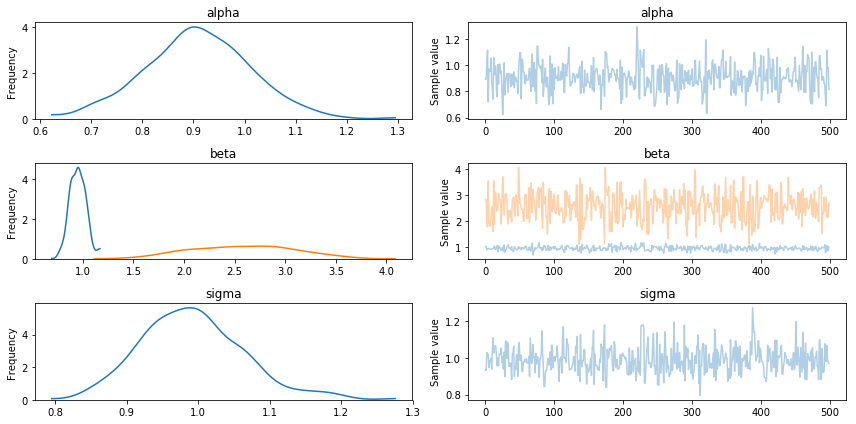

In [47]:
traceplot(trace)

In [48]:
from pymc3 import summary

In [49]:
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.908            0.102            0.005            [0.703, 1.100]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.705          0.843          0.906          0.974          1.115


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.949            0.080            0.004            [0.790, 1.103]
  2.576            0.538            0.027            [1.590, 3.580]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.793          0.891          0.949          1.006          1.112
  1.590          2.166          2.579   

# Case study one: stochastic volatility

Need a network connection to get the data.

# Case study two: coal mining disasters

In [50]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)
disaster_data.shape, year.shape

((111,), (111,))

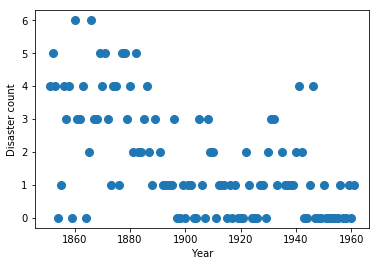

In [51]:
plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [53]:
from pymc3 import DiscreteUniform, Poisson, Exponential
from pymc3.math import switch

In [55]:
with Model() as disaster_model:
    switchpoint = DiscreteUniform('switchpoint', 
                                  lower=year.min(),
                                  upper=year.max(), testval=1900)

    early_rate = Exponential('early_rate', 1)
    late_rate = Exponential('late_rate', 1)
    
    # switch is a Theano function that works like an if statement
    rate = switch(switchpoint >= year, early_rate, late_rate)
    
    disasters = Poisson('disasters', rate, observed=disaster_data)

In [57]:
from pymc3 import Metropolis

In [58]:
with disaster_model:
    trace = sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log_
Assigned NUTS to late_rate_log_
Assigned Metropolis to disasters_missing
100%|██████████| 10000/10000 [00:10<00:00, 980.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124ced748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124fce160>]], dtype=object)

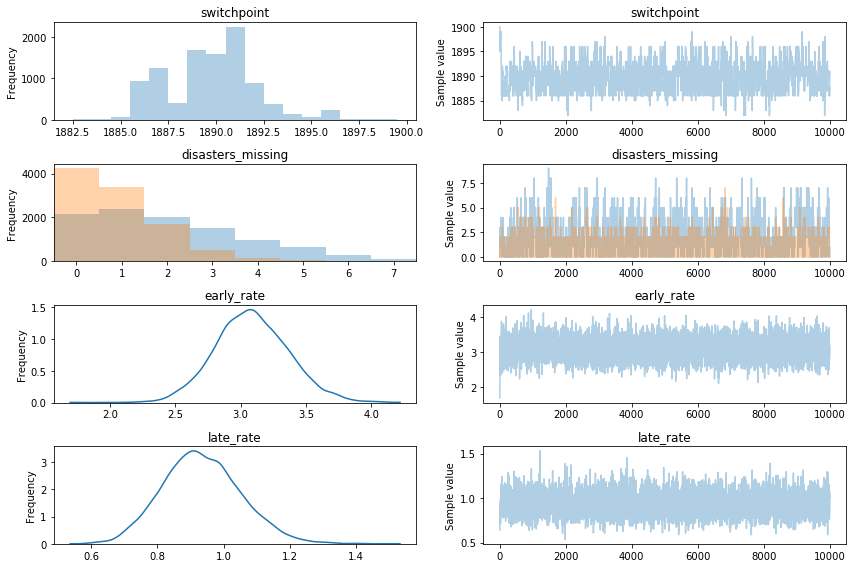

In [59]:
traceplot(trace)

In [60]:
summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1889.733         2.425            0.084            [1886.000, 1894.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1886.000       1888.000       1890.000       1891.000       1896.000


disasters_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.052            1.742            0.081            [0.000, 5.000]
  0.914            1.013            0.033            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          1.000          2.000          3.000          6.000
  0.000     

In [62]:
X1

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ,
        0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
       -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ,
       -0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
       -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732,
       -0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
       -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334,
       -1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
        1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267,
       -0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
        0.80723653,  0.04549008, -0.23309206, -1.19830114,  0.19

# GLMs using R syntax

In [63]:
import pandas as pd

In [66]:
df = pd.DataFrame({'X1':X1, 'X2':X2, 'y':Y})
df[:3]

,X1,X2,y
0,-1.085631,0.128411,0.938707
1,0.997345,-0.395578,0.410296
2,0.282978,0.142453,3.839813


In [69]:
from pymc3.glm import 

In [70]:
with Model() as model_glm:
    glm.from_xy('y ~ X1 + X2', df)
    glm.
    
    trace = sample()

ValueError: cannot copy sequence with size 3 to array axis with dimension 100